## Setup 

In [1]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from loguru import logger
import numpy as np
from valleyfloor.process_topography import process_topography
from valleyfloor.utils import setup_wbt

from slopes.subbasins import label_subbasins
from slopes.hillslopes import label_hillslopes
from slopes.detrend import detrend
from slopes.utils import finite_unique
from slopes.Clubb2017_qq import Clubb2017_qq_threshold
from slopes.network_xsections import network_xsections, observe_values

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
wbt = setup_wbt("~/opt/WBT/", "../working_dir")

dem = rxr.open_rasterio("../data/input/dem.tif", masked=True).squeeze()
flowlines = gpd.read_file("../data/input/flowlines.shp")

dataset, aligned_flowlines = process_topography(dem, flowlines, wbt)
aligned_flowlines = gpd.GeoSeries(aligned_flowlines['geometry'].values, index=aligned_flowlines['Stream_ID'])

dataset['subbasin'] = label_subbasins(dataset['flow_dir'], dataset['flow_acc'], dataset['flowpaths'], wbt)
dataset['hillslope'] = label_hillslopes(dataset['flowpaths'], dataset['flow_dir'], dataset['subbasin'], wbt)
dataset['slope_gradient'] = np.tan(np.radians(dataset['slope']))

dataset['hillshade'] = rxr.open_rasterio("../data/extra/hillshade.tif", masked=True).squeeze()

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/slopes-hCrF487D-py3.10/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


## Terrain Plot

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

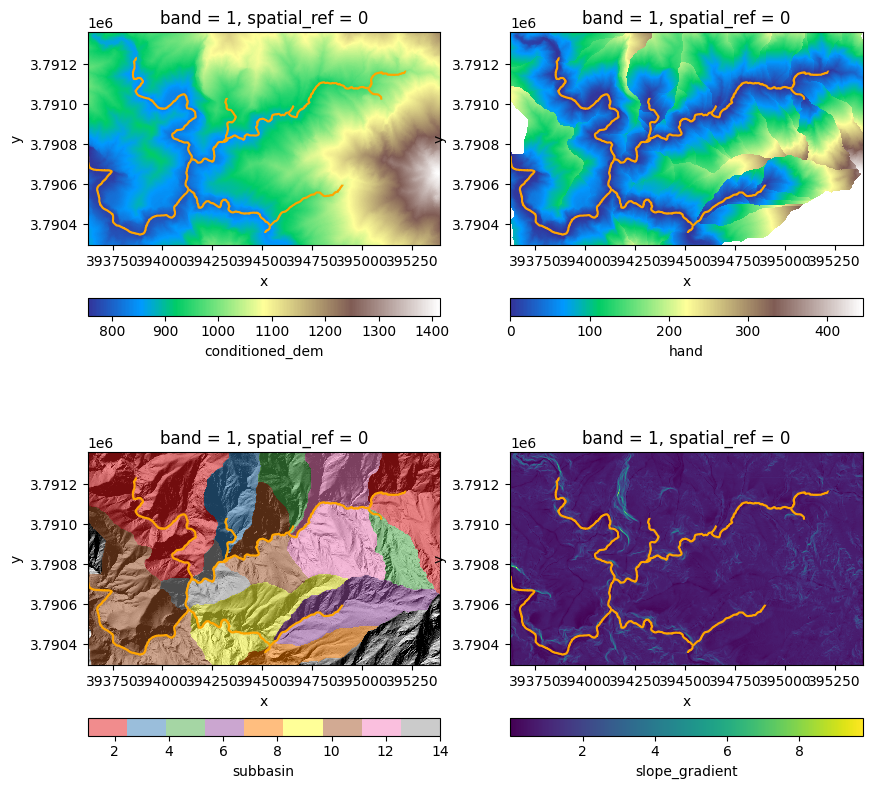

In [3]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

dataset['conditioned_dem'].plot(ax=axes[0,0], cmap='terrain', cbar_kwargs={'orientation': 'horizontal'})
aligned_flowlines.plot(ax=axes[0,0], color='orange')

dataset['hand'].plot(ax=axes[0,1], cmap='terrain', cbar_kwargs={'orientation': 'horizontal'})
aligned_flowlines.plot(ax=axes[0,1], color='orange')

dataset['hillshade'].plot(ax=axes[1,0], cmap='gray',  add_colorbar=False)
dataset['subbasin'].plot(ax=axes[1,0], cmap='Set1', alpha=0.5, cbar_kwargs={'orientation': 'horizontal'})
aligned_flowlines.plot(ax=axes[1,0], color='orange')


dataset['slope_gradient'].plot(ax=axes[1,1], cbar_kwargs={'orientation': 'horizontal'})
aligned_flowlines.plot(ax=axes[1,1], color='orange')


## Clubb 2017 Method

In [4]:
import scipy.stats as stats
import numpy as np

def norm_dist_from_percentiles(values, percentile_1, percentile_2):
    p1_val = np.percentile(values, percentile_1)
    p2_val = np.percentile(values, percentile_2)
    z1 = stats.norm.ppf(percentile_1/100)
    z2 = stats.norm.ppf(percentile_2/100)
    std = (p2_val - p1_val) / (z2 - z1)
    mean = p1_val - z1 * std
    norm = stats.norm(std, mean)
    return norm

In [85]:
def probplot(raster, ax=None, percentile_1=25, percentile_2=75, difference_threshold=0.01):
    values = raster.data.flatten()
    values = values[np.isfinite(values)]
    values = np.sort(values)

    # construct normal distribution from percentiles
    norm_dist = norm_dist_from_percentiles(values, percentile_1, percentile_2)

    osm, osr = stats.probplot(values, dist=norm_dist, plot=None, fit=False)
    diff = np.abs(osr - osm) / (values.max() - values.min())
    inds = diff < difference_threshold
    threshold_ind = np.argmax(inds)
    threshold = values[threshold_ind]

    osm_zscore = (osm - norm_dist.mean()) / norm_dist.std()

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(osm_zscore, osr)
    ax.plot(osm_zscore, osm, 'r')
    
    val1 = np.percentile(values, percentile_1)
    val2 = np.percentile(values, percentile_2)
    z1 = stats.norm.ppf(percentile_1/100)
    z2 = stats.norm.ppf(percentile_2/100)


    ax.plot(z1, val1, 'rD', markersize=4) 
    ax.plot(z2, val2, 'rD', markersize=4) 
    
    ax.plot(osm_zscore[threshold_ind], threshold, 'go') 

    ax.axvline(x=osm_zscore[threshold_ind], color='b', linestyle='--')
    ax.set_title(f'threshold: {threshold:.2f}')
    return threshold
    

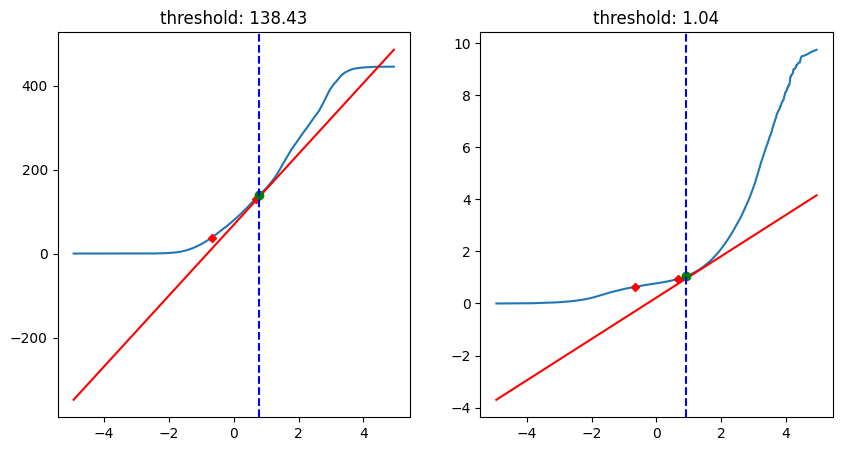

In [64]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
ht = probplot(dataset['hand'], ax=axes[0])
st = probplot(dataset['slope_gradient'], ax=axes[1])

In [35]:
raster = dataset['hand']
values = raster.data.flatten()
values = values[np.isfinite(values)]
values = np.sort(values)

    # construct normal distribution from percentiles
norm_dist = norm_dist_from_percentiles(values, 25, 75)

osm, osr = stats.probplot(values, dist=norm_dist, plot=None, fit=False)

In [38]:
osm

array([-348.2380748 , -333.3915987 , -325.37426728, ...,  462.42586162,
        470.44319304,  485.28966914])

In [40]:
len(osr)

1754838

In [71]:
diff_threshold = 0.005
import pandas as pd
df = pd.read_csv("/Users/arthurkoehl/programs/pasternack/topotools/elevation_1m_qq_.txt", delimiter='\s', skiprows=1, header=None)

/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/ipykernel_7976/1558123381.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("/Users/arthurkoehl/programs/pasternack/topotools/elevation_1m_qq_relief.txt", delimiter='\s', skiprows=1, header=None)


In [73]:
osm_z = df[0]
osr = df[1]
osm = df[2]

In [74]:
diff = np.abs(osr - osm)/(osr.max() - osr.min())

In [77]:
np.argmax(diff < diff_threshold)

np.int64(2079)

In [82]:
hand = rxr.open_rasterio("/Users/arthurkoehl/programs/pasternack/topotools/PARAMS_channel_relief.bil", masked=True)

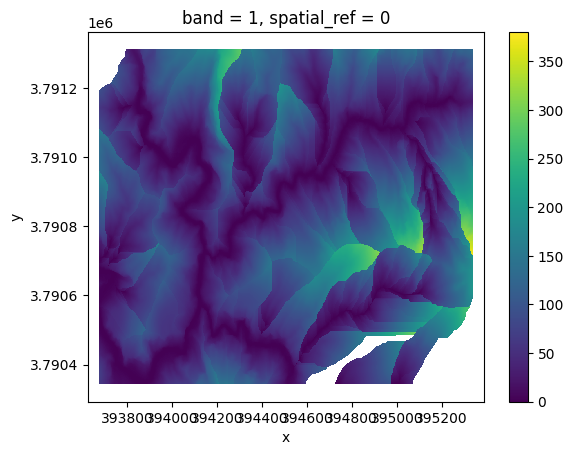

In [83]:
hand.plot()

np.float32(105.58441)

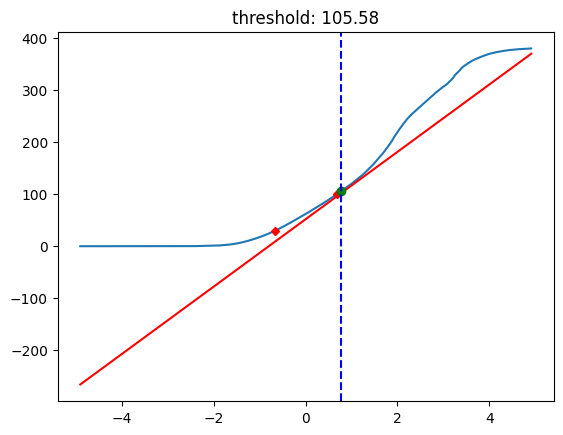

In [86]:
probplot(hand, ax=None, percentile_1=25, percentile_2=75, difference_threshold=0.01)

In [87]:
osr

0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
         ...   
9995    332.216
9996    337.621
9997    345.020
9998    351.439
9999    360.201
Name: 1, Length: 10000, dtype: float64

In [88]:
osm

0      -128.872
1      -119.565
2      -113.923
3      -109.820
4      -106.579
         ...   
9995    235.875
9996    239.116
9997    243.216
9998    248.862
9999    258.169
Name: 2, Length: 10000, dtype: float64

In [92]:
values = hand.data.flatten()
values = values[np.isfinite(values)]
values = np.sort(values)

first = np.percentile(values, 25)
second = np.percentile(values, 75)
clipped = values[values > first]
clipped = clipped[clipped < second]

In [94]:
clipped.mean(), clipped.std()

(np.float32(62.859695), np.float32(19.696758))

In [96]:
osm.mean(), osm.std()

(np.float64(64.64814893611), np.float64(51.996154849711985))